In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install spectral

     |████████████████████████████████| 184kB 6.8MB/s 
  Created wheel for spectral: filename=spectral-0.22.2-cp37-none-any.whl size=212938 sha256=533b7d739a38aa304ad3662c3b810c13d44930e976a1daf954c7ad249d8ce172
  Stored in directory: /root/.cache/pip/wheels/fb/00/da/ac778d1ab6e196cb7f56d104d4dfdfc0aad4e2b208275c0726
Successfully built spectral


In [3]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input, ZeroPadding3D, Activation, AveragePooling3D, MaxPooling3D, GlobalMaxPooling2D, Add, GlobalAveragePooling3D
from keras.models import Model
from keras.models import Sequential
from keras import models
from keras import layers
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.initializers import glorot_uniform

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from spectral import spy_colors
import scipy.io as sio
import os
import spectral
import time
init_notebook_mode(connected=True)
%matplotlib inline

In [4]:
## GLOBAL VARIABLES
dataset = 'B'
test_ratio = 0.3
windowSize = 5

In [5]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'/content/drive/MyDrive/data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    elif name == 'B':
        data = sio.loadmat(os.path.join(data_path, 'Botswana.mat'))['Botswana']
        labels = sio.loadmat(os.path.join(data_path, 'Botswana_gt.mat'))['Botswana_gt']
    
    
    return data, labels

In [6]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
# def applyPCA(X, numComponents=75):
#     newX = np.reshape(X, (-1, X.shape[2]))
#     pca = PCA(n_components=numComponents, whiten=True)
#     newX = pca.fit_transform(newX)
#     newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
#     return newX, pca

In [7]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [8]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [9]:
# data Loading
XX, y = loadData(dataset)
XX= ((XX-np.mean(XX))/np.std(XX))
# print(XX)
XX.shape, y.shape

((1476, 256, 145), (1476, 256))

In [10]:
K = XX.shape[2]
XX.shape[2]

145

In [ ]:
# K = 30 if dataset == 'IP' else 15
# XX,pca = applyPCA(XX,numComponents=K)

# XX.shape

In [11]:
XX, y = createImageCubes(XX, y, windowSize=windowSize)

XX.shape, y.shape

((3248, 5, 5, 145), (3248,))

In [12]:
# Training and testing patches spitining
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(XX, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((2273, 5, 5, 145), (975, 5, 5, 145), (2273,), (975,))

In [13]:
#train data reshape
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(2273, 5, 5, 145, 1)

In [14]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(2273, 14)

In [15]:
S = windowSize
L = K
if dataset == 'PU' or dataset == 'PC':
    output_units = 9
elif dataset == 'IP' or dataset == 'SA':
     output_units = 16
elif dataset == 'B':
     output_units = 14

In [16]:
def Nopooling(input_shape=(S,S,L,1)):
  # Define the input as a tensor with shape input_shape
  X_input = Input(input_shape)
  x=X_input
  # Stage 1
  conv_layer1 = Conv3D(filters=16, kernel_size=(3, 3, 7), activation='relu',padding="same")(x)
  conv_layer2 = Conv3D(filters=32, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
  conv_layer3 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
  #conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
  ## Faltten 3D Convolutional Layer
  flatten_layer = Flatten()(conv_layer3)
  dense_layer2 = Dense(units=128, activation='relu')(flatten_layer)
  output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

  # # define the model with input layer and output layer
  model = Model(inputs = X_input, outputs = output_layer, name='3DCNN')
  

  return model

In [17]:
model=Nopooling(input_shape=(S,S,L,1))
model.summary()

Model: "3DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 5, 145, 1)]    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 5, 5, 145, 16)     1024      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 3, 141, 32)     23072     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 1, 139, 64)     55360     
_________________________________________________________________
flatten (Flatten)            (None, 8896)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1138816   
_________________________________________________________________
dense_1 (Dense)              (None, 14)                1806  

In [18]:
# checkpoint
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/NoDR/BotswanaDataset/B/best-model.hdf5", monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [19]:
# model= ResNet18(input_shape=(S,S,L,1), classes=16)

tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
  model = Nopooling(input_shape=(S,S,L,1))
  adam = Adam(lr=0.001, decay=1e-06)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  start = time.time()

  history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=300, callbacks=callbacks_list)
      
  end = time.time()
  cnn_mnist_time = end-start
  print("Total training time is {:0.2f} minute".format(cnn_mnist_time/60.0))

INFO:tensorflow:Initializing the TPU system: grpc://10.105.111.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.105.111.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/300
9/9 [==============================] - 26s 2s/step - loss: 2.4991 - accuracy: 0.1593

Epoch 00001: accuracy improved from -inf to 0.25649, saving model to /content/drive/MyDrive/Colab Notebooks/NoDR/BotswanaDataset/B/best-model.hdf5
Epoch 2/300
9/9 [==============================] - 0s 28ms/step - loss: 1.3852 - accuracy: 0.4530

Epoch 00002: accuracy improved from 0.25649 to 0.47030, saving model to /content/drive/MyDrive/Colab Notebooks/NoDR/BotswanaDataset/B/best-model.hdf5
Epoch 3/300
9/9 [==============================] - 0s 26ms/step - loss: 0.9215 - accuracy: 0.6555

Epoch 00003: accuracy improved from 0.47030 to 0.66476, saving model to /content/drive/MyDrive/Colab Notebooks/NoDR/BotswanaDataset/B/best-model.hdf5
Epoch 4/300
9/9 [==============================] - 0s 27ms/step - loss: 0.6090 - accuracy: 0.7807

Epoch 00004: accuracy improved from 0.66476 to 0.78839, saving model to /content/drive/MyDrive/Colab Notebooks/NoDR/BotswanaDataset/B/best-model.hdf5
Epoch 5/

In [ ]:
# tf.keras.backend.clear_session()

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)

# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

# strategy = tf.distribute.experimental.TPUStrategy(resolver)

# with strategy.scope():
#   model= Nopooling(input_shape=(S,S,L,1), classes=16)
#   # compiling the model
#   adam = Adam(lr=0.001, decay=1e-06)
#   model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#   start = time.time()

#   history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=300, callbacks=callbacks_list)

#   end = time.time()
#   cnn_mnist_time = end-start
#   print("Total training time is {:0.2f} minute".format(cnn_mnist_time/60.0))

In [20]:
# load best weights
model.load_weights("/content/drive/MyDrive/Colab Notebooks/NoDR/BotswanaDataset/B/best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.title('model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.grid(True)
# plt.legend(['Training'], loc='upper left') 
# plt.savefig("/content/drive/MyDrive/Colab Notebooks/3DCNN/model_accuracy_100.svg")
# plt.show()

# # summarize history for loss 
# plt.plot(history.history['loss'])
# plt.title('model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.grid(True)
# plt.legend(['Training'], loc='upper left') 
# plt.savefig("/content/drive/MyDrive/Colab Notebooks/3DCNN/model_loss_100.svg")
# plt.show()

In [21]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(975, 5, 5, 145, 1)

In [22]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(975, 14)

In [23]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        81
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        75
           3       1.00      1.00      1.00        65
           4       0.99      0.99      0.99        81
           5       0.99      0.98      0.98        81
           6       1.00      1.00      1.00        78
           7       1.00      1.00      1.00        61
           8       0.99      0.99      0.99        94
           9       1.00      0.99      0.99        74
          10       0.99      1.00      0.99        92
          11       1.00      1.00      1.00        54
          12       0.99      1.00      0.99        80
          13       1.00      1.00      1.00        29

    accuracy                           0.99       975
   macro avg       1.00      1.00      1.00       975
weighted avg       0.99      0.99      0.99       975



In [24]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [25]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    elif name == 'B':
        target_names = ['Water','Hippo grass','Floodplain grasses 1','Floodplain grasses 2', 'Reeds','Riparian','Fire scar',
                        'Island interior','Acacia woodlands', 'Acacia shrublands', 'Acacia grasslands', 'Short mopane', 'Mixed mopane', 'Exposed soils']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [26]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "/content/drive/MyDrive/Colab Notebooks/NoDR/BotswanaDataset/B/classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

31/31 [==============================] - 6s 73ms/step - loss: 0.0177 - accuracy: 0.9964


In [27]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [28]:
# load the original image
XX, y = loadData(dataset)

In [29]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
#XX,pca = applyPCA(XX, numComponents=numComponents)

In [30]:
XX = padWithZeros(XX, PATCH_SIZE//2)

In [31]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(XX,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

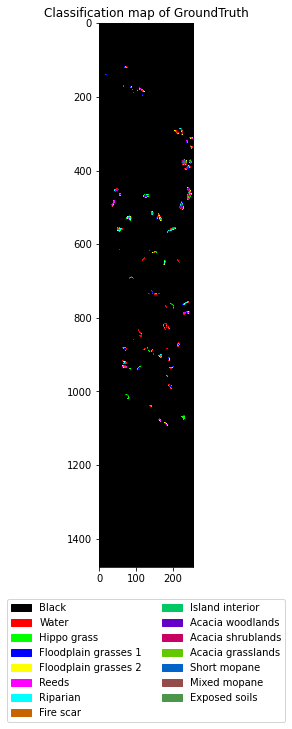

In [32]:
ground_truth = spectral.imshow(classes = y,figsize =(10,10))
plt.title('Classification map of GroundTruth')

if dataset == 'IP':
  labelDictionary= {1:'Alfalfa', 2:'Corn-notill', 3:'Corn-mintill', 4:'Corn',
                    5:'Grass-pasture', 6:'Grass-trees', 7:'Grass-pasture-mowed', 
                    8:'Hay-windrowed', 9:'Oats', 10:'Soybean-notill', 11:'Soybean-mintill',
                    12:'Soybean-clean', 13:'Wheat', 14:'Woods', 15:'Buildings-Grass-Trees-Drives',
                    16:'Stone-Steel-Towers', 0:'Black'}
elif dataset == 'SA':
  labelDictionary = {1:'Brocoli_green_weeds_1', 2:'Brocoli_green_weeds_2', 3:'Fallow', 4:'Fallow_rough_plow', 5:'Fallow_smooth',
                     6:'Stubble', 7:'Celery', 8:'Grapes_untrained', 9:'Soil_vinyard_develop', 10:'Corn_senesced_green_weeds',
                    11:'Lettuce_romaine_4wk', 12:'Lettuce_romaine_5wk', 13:'Lettuce_romaine_6wk', 14:'Lettuce_romaine_7wk',
                    15:'Vinyard_untrained', 16:'Vinyard_vertical_trellis', 0:'Black'}
elif dataset == 'PU':
  labelDictionary = {1:'Asphalt', 2:'Meadows', 3:'Gravel', 4:'Trees', 5:'Painted metal sheets', 6:'Bare Soil', 7:'Bitumen',
                      8:'Self-Blocking Bricks', 9:'Shadows', 0:'Black'}
elif dataset == 'B':
  labelDictionary = {1:'Water', 2:'Hippo grass', 3:'Floodplain grasses 1', 4:'Floodplain grasses 2', 5:'Reeds', 6:'Riparian', 7:'Fire scar',
                        8:'Island interior', 9:'Acacia woodlands', 10:'Acacia shrublands', 11:'Acacia grasslands', 12:'Short mopane', 13:'Mixed mopane', 14:'Exposed soils', 0:'Black'}

labelPatches = [ patches.Patch(color=spy_colors[x]/255.,
                 label=labelDictionary[x]) for x in np.unique(y) ]

plt.legend(handles=labelPatches,ncol=2, fontsize='medium', 
           loc='upper center', bbox_to_anchor=(0.5, -0.05))

Text(0.5, 1.0, 'Predicted Classification map 3DCNN')

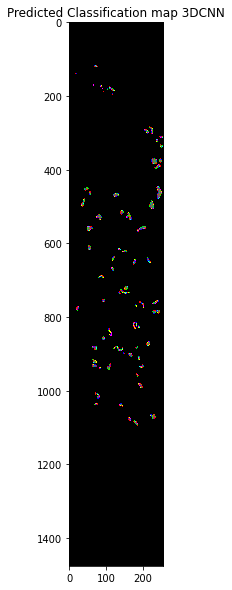

In [33]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(10,10))
plt.title('Predicted Classification map 3DCNN')
# plt.legend(handles=labelPatches,ncol=2, fontsize='medium', 
#            loc='upper center', bbox_to_anchor=(0.5, -0.05))

In [34]:
spectral.save_rgb("/content/drive/MyDrive/Colab Notebooks/NoDR/BotswanaDataset/B/predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)
spectral.save_rgb("/content/drive/MyDrive/Colab Notebooks/NoDR/BotswanaDataset/B/ground truth.jpg", y, colors=spectral.spy_colors)

In [ ]:
f = open("/content/drive/MyDrive/Colab Notebooks/NoDR/BotswanaDataset/classification_report.txt", "r")
print(f.read())

2.3626893758773804 Test loss (%)
99.28205013275146 Test accuracy (%)

99.22210165906054 Kappa accuracy (%)
99.28205128205128 Overall accuracy (%)
99.2449998123757 Average accuracy (%)

                      precision    recall  f1-score   support

               Water       1.00      1.00      1.00        81
         Hippo grass       1.00      0.97      0.98        30
Floodplain grasses 1       1.00      1.00      1.00        75
Floodplain grasses 2       1.00      1.00      1.00        65
               Reeds       0.99      1.00      0.99        81
            Riparian       0.97      0.94      0.96        81
           Fire scar       1.00      1.00      1.00        78
     Island interior       1.00      1.00      1.00        61
    Acacia woodlands       0.96      0.99      0.97        94
   Acacia shrublands       1.00      1.00      1.00        74
   Acacia grasslands       1.00      1.00      1.00        92
        Short mopane       1.00      1.00      1.00        54
        

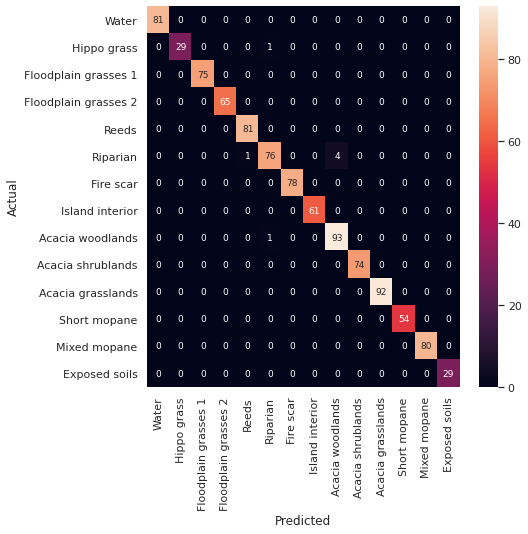

In [ ]:
import pandas as pd
import seaborn as sn

names = ['Water','Hippo grass','Floodplain grasses 1','Floodplain grasses 2', 'Reeds','Riparian','Fire scar',
                        'Island interior','Acacia woodlands', 'Acacia shrublands', 'Acacia grasslands', 'Short mopane', 'Mixed mopane', 'Exposed soils']

Y_pred = model.predict(Xtest)
y_pred = np.argmax(Y_pred, axis=1)


mat = confusion_matrix(np.argmax(ytest, axis=1), y_pred)

df_cm = pd.DataFrame(mat, columns=names, index = names)

df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (7,7))
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}, fmt='d')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/NoDR/BotswanaDataset/cmap.png', dpi=300)